In [15]:
# Import necessary libraries
import os

import pandas as pd
from IPython.core.display_functions import display
from matplotlib import pyplot as plt

# Assuming access_times is a custom module with necessary functions
import access_times


def read_and_process_files(input_dir, file_packages_suffix, file_usage_suffix, stale_age=45):
    """
    Reads and processes package files and usage logs to generate insights into file access patterns.
    
    Parameters:
    - input_dir: Directory containing the input files.
    - file_packages_suffix: Suffix for package files.
    - file_usage_suffix: Suffix for usage log files.
    
    Returns:
    - A collection of DataFrames with processed data.
    """
    # Construct file paths
    packages_input_file = os.path.join(input_dir, f"{input_dir}-{file_packages_suffix}")
    usage_input_file = os.path.join(input_dir, f"{input_dir}-{file_usage_suffix}")

    # Define columns for reading CSVs
    files_packages_columns = ['path', 'package']
    files_info_columns = ['path', 'creation_time', 'access_time']

    # Read and process package files
    files_packages_df, dirty_packages = access_times.read_csv_filter_convert(
        packages_input_file, files_packages_columns, 0, '|')

    # Read and process usage logs
    df, non_convertible_count = access_times.read_csv_filter_convert(
        usage_input_file, files_info_columns, 2, delimiter='|')

    # Process access times
    seconds_in_a_day = 86400
    df['access_time_days'] = (df['access_time'] // seconds_in_a_day).astype(int)
    min_day = df['access_time_days'].min()
    df['access_time_days_normalized'] = df['access_time_days'] - min_day

    # Identify unneeded files based on access times
    access_time_max = df['access_time_days_normalized'].max() - stale_age
    unneeded_files = df[df['access_time_days_normalized'] > access_time_max]

    # Aggregate data to count files per normalized access day
    daily_counts = df.groupby('access_time_days_normalized').size()

    # Merge DataFrames to identify unmatched files
    merged_df = pd.merge(files_packages_df, df, on='path', how='outer', indicator=True)
    merged_df['directory'] = merged_df['path'].apply(lambda x: os.path.dirname(x) if pd.notnull(x) else x)
    merged_df.fillna({'package': 'Unknown', 'creation_time': pd.NaT, 'access_time': pd.NaT}, inplace=True)
    merged_df = merged_df[~merged_df['package'].str.contains('Unknown|unknown')]

    return files_packages_df, daily_counts, merged_df, unneeded_files


def generate_visualizations(daily_counts):
    """
    Generates visualizations for daily file access counts.
    
    Parameters:
    - daily_counts: A Series containing the counts of file accesses per day.
    """
    plt.figure(figsize=(12, 6))
    plt.fill_between(daily_counts.index, daily_counts.values, step="pre", alpha=0.4)
    plt.plot(daily_counts.index, daily_counts.values, label='Files LastAccessed Day')
    plt.title('File Access Distribution Over Days')
    plt.xlabel('Days Since System Build')
    plt.ylabel('Number of Files Accessed')
    plt.legend()
    plt.grid(True)
    plt.show()


def generate_reports(merged_df):
    """
    Generates reports based on the merged data of files and packages.
    
    Parameters:
    - merged_df: The DataFrame resulting from merging package and access time data.
    """
    # Identify and report on unmatched files
    unreported_files_packages = merged_df[merged_df['_merge'] == 'left_only']
    non_packaged_files = merged_df[merged_df['_merge'] == 'right_only']

    directory_counts = non_packaged_files.groupby('directory').size()
    top_10_directories = directory_counts.nlargest(10)

    print("Top 10 directories with non-packaged files and their file counts:")
    print(top_10_directories)


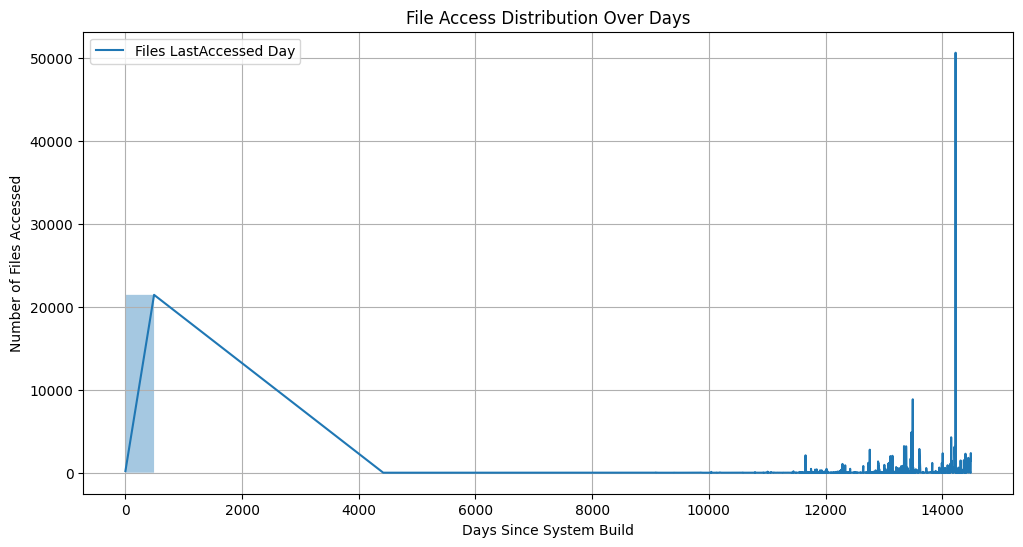

Top 10 directories with non-packaged files and their file counts:
Series([], dtype: int64)


In [18]:
input_dir = "insights-rand-1"
file_packages_suffix = "all_package_files.log"
file_usage_suffix = "usage.log"
min_age_package_to_hide = 45
# Process files
files_packages_df,  daily_counts, merged_df, unneeded_files = read_and_process_files(
    input_dir, file_packages_suffix, file_usage_suffix, min_age_package_to_hide)

# Generate visualizations
generate_visualizations(daily_counts)

    # Generate reports
generate_reports(merged_df)
merged_df_sorted = merged_df.sort_values("access_time")
latest_access_per_time = merged_df_sorted[["access_time", "package"]].groupby('access_time').tail(1)


In [19]:
from shlex import join

#  each package has multiple rows  display only the 20 packages with the largest access times records without duplicates
packages = (latest_access_per_time[["access_time", "package"]].drop_duplicates(["package"]))
never_include_packages = ["base-files", "coreutils"]  # replace with your list of package names
filtered_packages = packages[~packages["package"].isin(never_include_packages)]
dpkg_commands = [ pkg for pkg in filtered_packages["package"]]
print('20 packages over 45 days old ')

# print each command
print('sudo dpkg -r ')
print(" ".join(dpkg_commands[:10]))
print(" ".join(dpkg_commands[-10:]))

20 packages over 45 days old 
sudo dpkg -r 
adduser libmagic1:amd64 screen command-not-found apparmor byobu console-setup-linux cron language-selector-common mdadm
motd-news-config python3-cffi-backend libmpdec2:amd64 python3-markupsafe libip4tc2:amd64 glib-networking:amd64 ubuntu-keyring libassuan0:amd64 libgirepository-1.0-1:amd64 libyaml-0-2:amd64
